In [55]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# two levels up from the notebook to project root, then append to sys.path
sys.path.append(str(Path().resolve().parents[1]))

PROJECT_ROOT = Path().resolve().parents[1]
RESULTS_PATH = PROJECT_ROOT / "results"


from utils.data_loading import load_datasets
from utils.data_preparation import get_spo2_to_po2_interpolator, add_shift_raw_column, add_engineered_features
from utils.evaluation import evaluate_macro_patient_level, print_evaluation, bland_altman_plots, bland_altman_pct_comparison
from utils.modeling import fit_cv_models, predict_cv_ensemble, average_linear_coeffs
from utils.logging import log_run_json


train_df, test_df, val_df, odc = load_datasets()
spo2_to_po2 = get_spo2_to_po2_interpolator(odc)




train_df_engineered = add_engineered_features(train_df, spo2_to_po2)
test_df_engineered = add_engineered_features(test_df, spo2_to_po2)
val_df_engineered = add_engineered_features(val_df, spo2_to_po2)

features = ['shift_raw', 'SpO2(%)', 'log_PiO2']
# features = ['shift_raw', 'SpO2_over_PiO2',  'SpO2_squared', 'log_PiO2']

train_sub = train_df_engineered[(train_df_engineered['SpO2(%)'] < 95) & (train_df_engineered['PiO2(kPa)'] < 30)]
test_sub = test_df_engineered[(test_df_engineered['SpO2(%)'] < 95) & (test_df_engineered['PiO2(kPa)'] < 30)]
val_sub = val_df_engineered[(val_df_engineered['SpO2(%)'] < 95) & (val_df_engineered['PiO2(kPa)'] < 30)]

In [56]:
full_train = pd.concat([train_df_engineered, test_df_engineered], ignore_index=True)

from sklearn.linear_model import BayesianRidge

final_model = BayesianRidge()
final_model.fit(full_train[features], full_train["shift"])


BayesianRidge()

In [57]:
val_sub = val_sub.copy()
val_sub["y_pred_final"] = final_model.predict(val_sub[features])

# Optional: evaluate on macro patient level
val_summary = evaluate_macro_patient_level(val_sub, y_true_col="shift", y_pred_col="y_pred_final")
print("Evaluation on final model (val set):")
print_evaluation(val_summary)


Evaluation on final model (val set):
Macro-averaged per-patient metrics:
MAE  = 0.604
MSE  = 0.708
RMSE = 0.690
Mean Bias Error = -0.039
MAPE = 5.346%
nRMSE = 4.512%


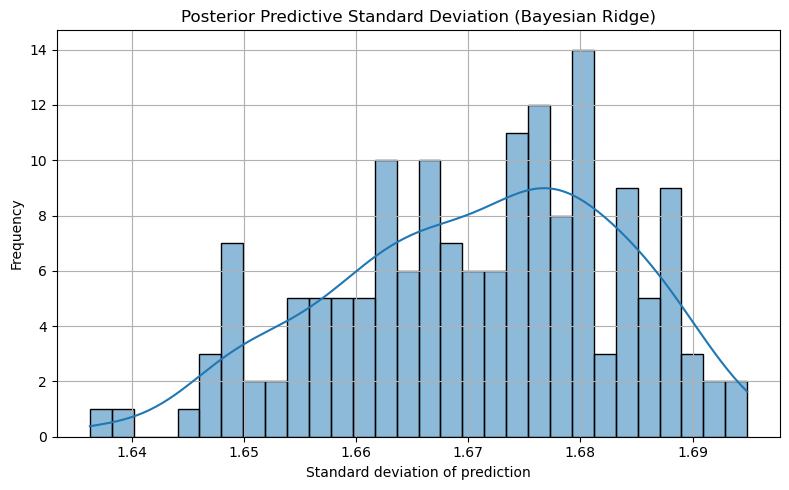

In [58]:
# Get predicted std deviation (posterior predictive std)
val_sub["y_pred_mean"], val_sub["y_pred_std"] = final_model.predict(val_sub[features], return_std=True)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(val_sub["y_pred_std"], bins=30, kde=True)
plt.title("Posterior Predictive Standard Deviation (Bayesian Ridge)")
plt.xlabel("Standard deviation of prediction")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [59]:
print(f"alpha_ (data noise precision): {final_model.alpha_:.4f}")
print(f"lambda_ (weight prior precision): {final_model.lambda_:.4f}")


alpha_ (data noise precision): 0.4790
lambda_ (weight prior precision): 0.0196


In [60]:
print("Standard deviation of the weights:")
print(np.std(final_model.coef_))


Standard deviation of the weights:
5.8576160008890765


In [61]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(val_sub["shift"], val_sub["y_pred_final"])
print("MAE:", mae)


MAE: 0.6017837009299059


In [62]:
print(val_sub["shift"].describe())


count    160.000000
mean      11.093687
std        2.791657
min        7.200000
25%        9.200000
50%       10.500000
75%       11.800000
max       22.500000
Name: shift, dtype: float64


In [63]:
within_95pct = (
    (val_sub["shift"] >= val_sub["y_pred_mean"] - 2 * val_sub["y_pred_std"]) &
    (val_sub["shift"] <= val_sub["y_pred_mean"] + 2 * val_sub["y_pred_std"])
)

print(f"Coverage of ±2 std interval: {within_95pct.mean():.1%}")


Coverage of ±2 std interval: 98.8%


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(full_train[features])
X_val_scaled = scaler.transform(val_sub[features])

# Re-fit model on scaled data
model = BayesianRidge()
model.fit(X_train_scaled, full_train["shift"])

# Predict on validation set
val_sub["y_pred_mean"], val_sub["y_pred_std"] = model.predict(X_val_scaled, return_std=True)


In [68]:
val_summary = evaluate_macro_patient_level(val_sub, y_true_col="shift", y_pred_col="y_pred_mean")
print("Evaluation on final model (val set):")
print_evaluation(val_summary)

Evaluation on final model (val set):
Macro-averaged per-patient metrics:
MAE  = 0.604
MSE  = 0.708
RMSE = 0.690
Mean Bias Error = -0.040
MAPE = 5.347%
nRMSE = 4.513%


In [70]:
print(f"alpha_ (data noise precision): {model.alpha_:.4f}")
print(f"lambda_ (weight prior precision): {model.lambda_:.4f}")
print("Standard deviation of the weights:")
print(np.std(model.coef_))


alpha_ (data noise precision): 0.4790
lambda_ (weight prior precision): 0.3227
Standard deviation of the weights:
1.5596474404190013


In [ ]:
print("Standard deviation of the weights:")
print(np.std(final_model.coef_))


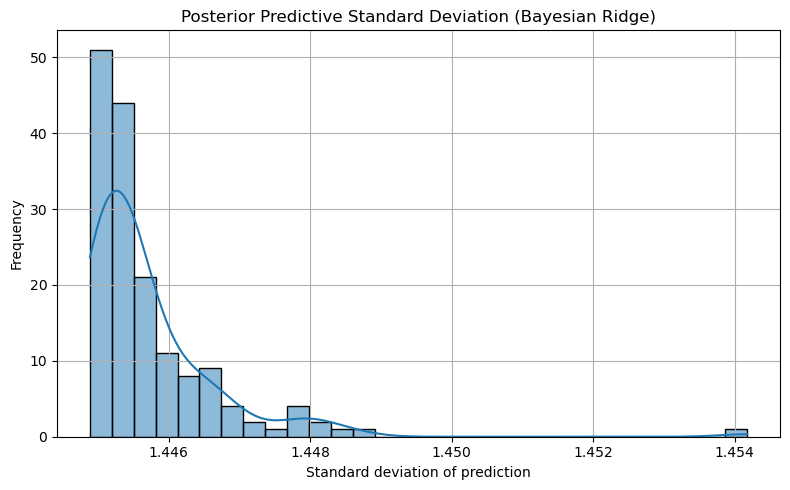

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(val_sub["y_pred_std"], bins=30, kde=True)
plt.title("Posterior Predictive Standard Deviation (Bayesian Ridge)")
plt.xlabel("Standard deviation of prediction")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

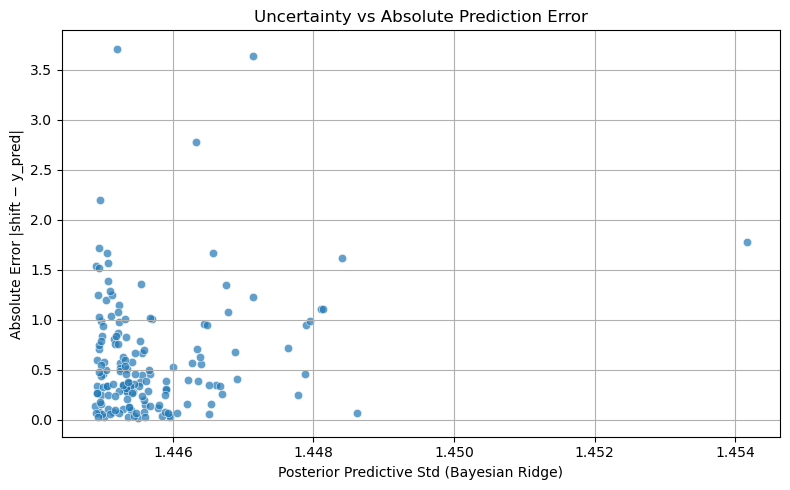

Pearson correlation: r = 0.195, p = 1.336e-02


In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute absolute error per datapoint
val_sub["abs_error"] = np.abs(val_sub["shift"] - val_sub["y_pred_mean"])

# Scatter plot: std vs abs error
plt.figure(figsize=(8, 5))
sns.scatterplot(data=val_sub, x="y_pred_std", y="abs_error", alpha=0.7)
plt.xlabel("Posterior Predictive Std (Bayesian Ridge)")
plt.ylabel("Absolute Error |shift − y_pred|")
plt.title("Uncertainty vs Absolute Prediction Error")
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Pearson correlation
from scipy.stats import pearsonr
r, p = pearsonr(val_sub["y_pred_std"], val_sub["abs_error"])
print(f"Pearson correlation: r = {r:.3f}, p = {p:.3e}")
